In [1]:
import gym
import numpy as np
import random
import time

In [2]:
import matplotlib.pyplot as plt

In [3]:
from tqdm import tqdm

In [4]:
#Cross-Entropy method
class CEM():
    def __init__(self, state_n, action_n):
        self.state_n = state_n
        self.action_n = action_n
        self.policy = np.ones((self.state_n, self.action_n)) / self.action_n
        
    def get_action(self, state):
        return int(np.random.choice(np.arange(self.action_n), p=self.policy[state]))
    
    def update_policy(self, elite_trjs):
        pre_policy = np.zeros((self.state_n, self.action_n))
        
        for trj in elite_trjs:
            for state, action in zip(trj['states'], trj['actions']):
                pre_policy[state][action] += 1
              
        for state in range(self.state_n):
            if sum(pre_policy[state]) == 0:
                self.policy[state] = np.ones(self.action_n) / self.action_n
            else:
                self.policy[state] = pre_policy[state] / sum(pre_policy[state])
        

    #create new update policy with smooth 
    def update_policy_smooth_1(self, elite_trjs, lambd):
        # pi = (|(a|s) in elite| + lambda) / (|s in elite| +lambda*|A|)

        pre_policy = np.zeros((self.state_n, self.action_n))
        for trajectory in elite_trjs:
            for state, action in zip(trajectory['states'], trajectory['actions']):
                    pre_policy[state][action] += 1

        for state in range(self.state_n):
            s = sum(pre_policy[state])
            pre_policy[state] += lambd
            pre_policy[state] /= (s + lambd*self.action_n)
        
        self.policy = pre_policy
    
    def update_policy_smooth_2(self, elite_trjs, lr):
        # pi_new = learning_rate*pi_new + (1-learning_rate)*pi_old 
        pi_old = self.policy
        self.update_policy(elite_trjs)
        
        
        for state in range(state_n):
            self.policy[state] = lr*self.policy[state] +(1-lr)*pi_old[state]
    
        return None

In [5]:
#Create one trajectory for given agent
def get_trajectory(agent, trj_len):
    trajectory = {'states': [], 'actions': [], 'total_reward': 0}
    obs = env.reset()
    state = obs
    
    for _ in range(trj_len):
        trajectory['states'].append(state)
        action = agent.get_action(state)          
        trajectory['actions'].append(action)
        
        obs, reward, done, _ = env.step(action)
        
        state = obs
        trajectory['total_reward'] += reward
        
        if done:
            break
    return trajectory

In [6]:
#Create elite trajectories
def get_elite_trajectories(trajectories, q_param):
    total_rewards = [trj['total_reward'] for trj in trajectories]
    quantile = np.quantile(total_rewards, q_param)
    
    return [trajectory for trajectory in trajectories if trajectory['total_reward'] >= quantile]

In [7]:
state_n = 500
action_n = 6

In [25]:
env = gym.make('Taxi-v3')

#Try to find gyperparametrs
agent = CEM(state_n, action_n)
epochs = 20
trajectory_n = 50
trajectory_len = 100
q_param = 0.87

In [26]:
#training loop
history_rewards = []

for _ in tqdm(range(epochs)):
    trajectories = [get_trajectory(agent, trajectory_len) for _ in range(trajectory_n)]
    
    mean_total_reward = np.mean([trj['total_reward'] for trj in trajectories])
    history_rewards.append(mean_total_reward)
    
    elite_trjs = get_elite_trajectories(trajectories, q_param)
    if len(elite_trjs) > 0:
        agent.update_policy(elite_trjs)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.21it/s]


Mean total reard = -317.52


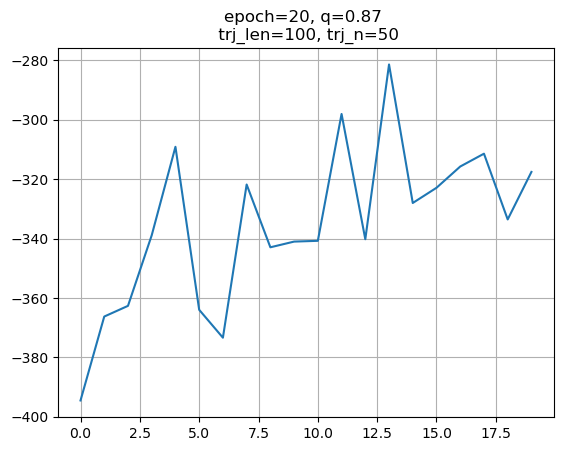

In [27]:
print(f'Mean total reard = {history_rewards[-1]}')
plt.plot(history_rewards)
plt.title('epoch=20, q=0.87 \n trj_len=100, trj_n=50')
plt.grid()
plt.savefig('1_1.png')
plt.show()

In [7]:
env = gym.make('Taxi-v3')

In [8]:
state_n = 500
action_n = 6

In [9]:
#Use the best gyperparametrs
agent = CEM(state_n, action_n)
epochs = 35
trajectory_n = 250
trajectory_len = 500
q_param = 0.45
lambd = 0.1
lr = 0.5

The best parametrs:

epochs = 35

trajectory_n = 250

trajectory_len = 500

q_parat = 0.45

In [94]:
#training loop
history_rewards = []

for _ in tqdm(range(epochs)):
    trajectories = [get_trajectory(agent, trajectory_len) for _ in range(trajectory_n)]
    
    mean_total_reward = np.mean([trj['total_reward'] for trj in trajectories])
    history_rewards.append(mean_total_reward)
    
    elite_trjs = get_elite_trajectories(trajectories, q_param)
    if len(elite_trjs) > 0:
        agent.update_policy_smooth_1(elite_trjs, lambd)

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [01:05<00:00,  1.86s/it]


Mean total reard = -43.896


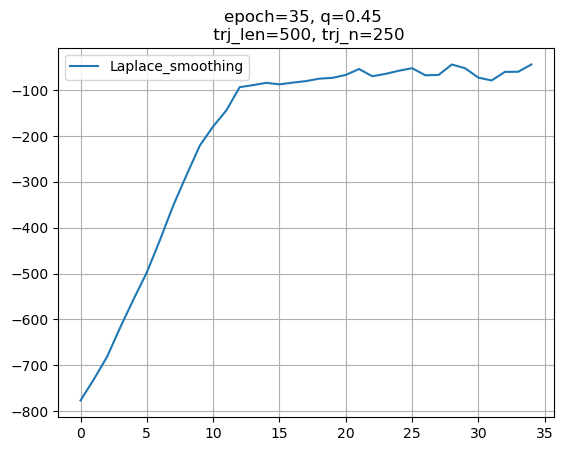

In [96]:
print(f'Mean total reard = {history_rewards[-1]}')
plt.plot(history_rewards, label='Laplace_smoothing')
plt.title('epoch=35, q=0.45 \n trj_len=500, trj_n=250')
plt.grid()
plt.legend()
plt.savefig('Laplace_smoothing.png')
plt.show()

In [10]:
#training loop
history_rewards = []

for _ in tqdm(range(epochs)):
    trajectories = [get_trajectory(agent, trajectory_len) for _ in range(trajectory_n)]
    
    mean_total_reward = np.mean([trj['total_reward'] for trj in trajectories])
    history_rewards.append(mean_total_reward)
    
    elite_trjs = get_elite_trajectories(trajectories, q_param)
    if len(elite_trjs) > 0:
        agent.update_policy_smooth_2(elite_trjs, lr)

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:52<00:00,  1.51s/it]


Mean total reard = -103.96


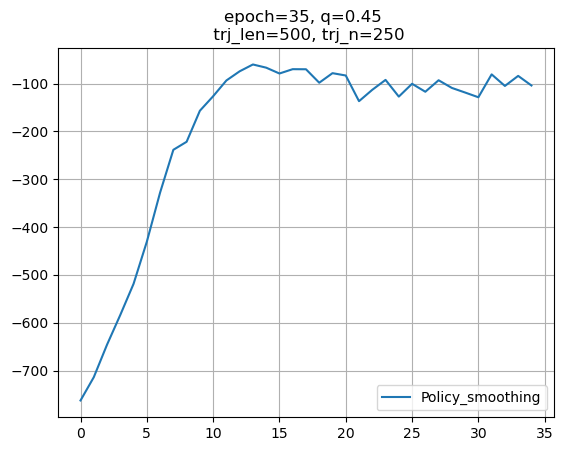

In [11]:
print(f'Mean total reard = {history_rewards[-1]}')
plt.plot(history_rewards, label='Policy_smoothing')
plt.title('epoch=35, q=0.45 \n trj_len=500, trj_n=250')
plt.grid()
plt.legend()
plt.savefig('Policy_smoothing.png')
plt.show()

Общее вознаграждение по порядку такое же, как и в предыдущих случаях, но визуально агент играет лучше

In [13]:
#test
env = gym.make('Taxi-v3')
obs = env.reset()
state = obs

for _ in range(trajectory_len):

    action = agent.get_action(state)

    obs, reward, done, _ = env.step(action)
    state = obs
    
    #print(action)
    
    env.render()
    time.sleep(0.2)

    if done:
        break

        
env.close()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | :_:G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: |_: :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : |_: : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| :_| : : |
| : : : : |
| | : | : |
|Y|

In [7]:
#Create elite trajectories for stochastic env
def get_elite_trajectories_stochastic(agent, q_param, M, K):
    #K == trajectory_n
    #M == number of samples determenistic policies
    
    trjs = []  
    pi = []
    
    for m in range(M):               
        pi_m = np.zeros((state_n, action_n))
        for state in range(state_n):
            pi_m[state][np.random.choice(np.arange(action_n), p=agent.policy[state])] = 1
        pi.append(pi_m)

    for m in range(M):
        ag = CEM(state_n, action_n)
        ag.policy = pi[m]
        trjs_m = [get_trajectory(ag, trajectory_len) for _ in range(K)] 
        trjs.append(trjs_m)
            
    v = np.zeros(M)
    for m in range(M):
        v[m] = np.mean([trj['total_reward'] for trj in trjs[m]])
    
    quantile = np.quantile(v, q_param)
            
    elite = []
    
    for m in range(M):
        if v[m] >= quantile:
            elite.extend(trjs[m])
            
    return elite, v

In [8]:
env = gym.make('Taxi-v3')

C:\Users\Egor\anaconda3\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\Egor\anaconda3\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [9]:
state_n = 500
action_n = 6

In [10]:
#Use the best gyperparametrs
agent = CEM(state_n, action_n)
epochs = 35
trajectory_n = 250
trajectory_len = 500
q_param = 0.45
lambd = 0.3
lr = 0.5
M = 10

The best parametrs:

epochs = 35

trajectory_n = 250

trajectory_len = 500

q_param = 0.45

In [11]:
#training loop
history_rewards = []

for _ in tqdm(range(epochs)):
    #trajectories = [get_trajectory(agent, trajectory_len) for _ in range(trajectory_n)] 
    
    elite_trajectories, mean_stochastic_rewards = get_elite_trajectories_stochastic(agent, q_param, M, trajectory_n)  
    
    
    #mean_total_stochastic_reward = np.mean(mean_stochastic_rewards)
    history_rewards.append(mean_stochastic_rewards)
    
    #elite_trjs = get_elite_trajectories(trajectories, q_param)
    
    if len(elite_trajectories) > 0:
        agent.update_policy(elite_trajectories)

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [41:17<00:00, 70.78s/it]


Mean total reward = [-1250.588 -1120.772 -1236.008 -1250.336 -1243.208 -1207.46  -1142.624
 -1135.46  -1171.208 -1207.532]


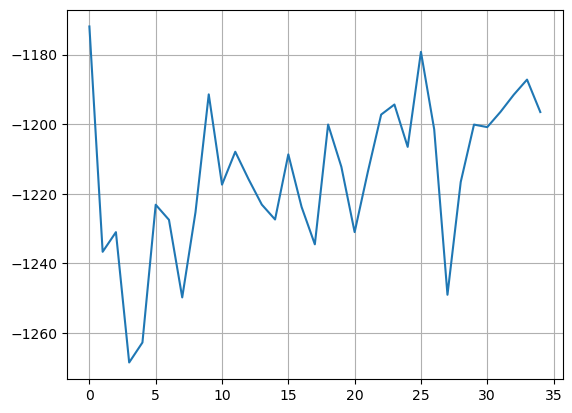

In [14]:
print(f'Mean total reward = {history_rewards[-1]}')
res = [np.mean(v) for v in history_rewards]
plt.plot(res)
plt.grid()
plt.show()

In [11]:
#training loop
history_rewards = []

for _ in tqdm(range(epochs)):
    #trajectories = [get_trajectory(agent, trajectory_len) for _ in range(trajectory_n)] 
    
    elite_trajectories, mean_stochastic_rewards = get_elite_trajectories_stochastic(agent, q_param, M, trajectory_n)  
    
    
    #mean_total_stochastic_reward = np.mean(mean_stochastic_rewards)
    history_rewards.append(mean_stochastic_rewards)
    
    #elite_trjs = get_elite_trajectories(trajectories, q_param)
    
    if len(elite_trajectories) > 0:
        agent.update_policy_smooth_2(elite_trajectories, lr)

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [23:38<00:00, 40.52s/it]


Mean total reward = [-1264.736 -1272.26  -1113.788 -1099.388 -1315.46  -1120.844 -1185.788
 -1192.808 -1135.352 -1200.152]


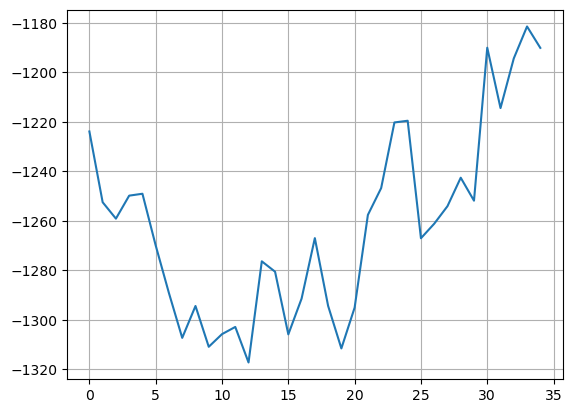

In [12]:
print(f'Mean total reward = {history_rewards[-1]}')
res = [np.mean(v) for v in history_rewards]
plt.plot(res)
plt.grid()
plt.show()

In [11]:
#training loop
history_rewards = []

for _ in tqdm(range(epochs)):
    #trajectories = [get_trajectory(agent, trajectory_len) for _ in range(trajectory_n)] 
    
    elite_trajectories, mean_stochastic_rewards = get_elite_trajectories_stochastic(agent, q_param, M, trajectory_n)  
    
    
    #mean_total_stochastic_reward = np.mean(mean_stochastic_rewards)
    history_rewards.append(mean_stochastic_rewards)
    
    #elite_trjs = get_elite_trajectories(trajectories, q_param)
    
    if len(elite_trajectories) > 0:
        agent.update_policy_smooth_1(elite_trajectories, lambd)

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [24:01<00:00, 41.18s/it]


Mean total reward = [-1214.912 -1128.728 -1215.128 -1229.6   -1150.364 -1222.328 -1243.964
 -1200.548 -1258.328 -1236.656]


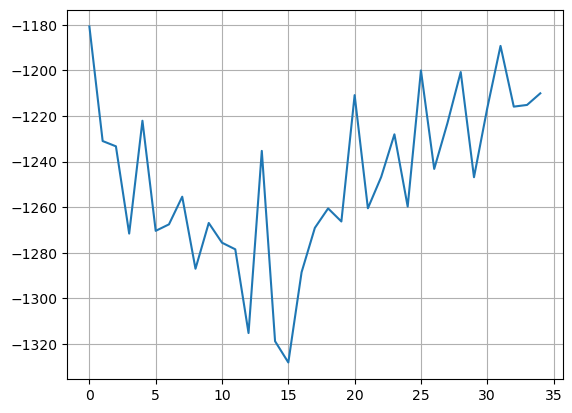

In [12]:
print(f'Mean total reward = {history_rewards[-1]}')
res = [np.mean(v) for v in history_rewards]
plt.plot(res)
plt.grid()
plt.show()

In [10]:
#training loop
history_rewards = []

for _ in tqdm(range(epochs)):
    trajectories = [get_trajectory(agent, trajectory_len) for _ in range(trajectory_n)]
    
    mean_total_reward = np.mean([trj['total_reward'] for trj in trajectories])
    history_rewards.append(mean_total_reward)
    
    elite_trjs = get_elite_trajectories(trajectories, q_param)
    if len(elite_trjs) > 0:
        agent.update_policy_smooth_1(elite_trjs, lambd)

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [01:40<00:00,  2.88s/it]


Mean total reard = -91.964


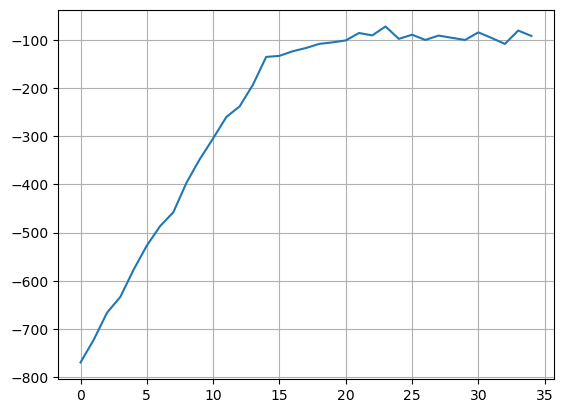

In [11]:
print(f'Mean total reard = {history_rewards[-1]}')
plt.plot(history_rewards)
plt.grid()
plt.show()

Общее вознаграждение остается примерно таким же и визуально агент играет с той же точностью, что и без сглаживания

In [79]:
#training loop
history_rewards = []

for _ in tqdm(range(epochs)):
    trajectories = [get_trajectory(agent, trajectory_len) for _ in range(trajectory_n)]
    
    mean_total_reward = np.mean([trj['total_reward'] for trj in trajectories])
    history_rewards.append(mean_total_reward)
    
    elite_trjs = get_elite_trajectories(trajectories, q_param)
    if len(elite_trjs) > 0:
        agent.update_policy_smooth_2(elite_trjs, lr)

  3%|██▎                                                                                | 1/35 [00:02<01:09,  2.06s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.13888889 0.2037037  0.15740741 0.19444444 0.15740741 0.14814815]
 [0.16666667 0.19047619 0.04761905 0.16666667 0.21428571 0.21428571]
 ...
 [0.16438356 0.20547945 0.20547945 0.1369863  0.10958904 0.17808219]
 [0.14285714 0.25       0.25       0.         0.21428571 0.14285714]
 [0.         0.25       0.         0.5        0.         0.25      ]]


  6%|████▋                                                                              | 2/35 [00:06<01:54,  3.46s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.16853933 0.25842697 0.1011236  0.16853933 0.1011236  0.20224719]
 [0.23076923 0.05128205 0.05128205 0.30769231 0.15384615 0.20512821]
 ...
 [0.11538462 0.19230769 0.17307692 0.19230769 0.17307692 0.15384615]
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.2        0.         0.5        0.         0.3       ]]


  9%|███████                                                                            | 3/35 [00:11<02:19,  4.37s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.1827957  0.2688172  0.12903226 0.21505376 0.09677419 0.10752688]
 [0.16       0.04       0.         0.44       0.2        0.16      ]
 ...
 [0.06593407 0.23076923 0.15384615 0.23076923 0.21978022 0.0989011 ]
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.2        0.         0.5        0.         0.3       ]]


 11%|█████████▍                                                                         | 4/35 [00:17<02:25,  4.69s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.22972973 0.25675676 0.07432432 0.24324324 0.06756757 0.12837838]
 [0.22727273 0.01515152 0.         0.31818182 0.31818182 0.12121212]
 ...
 [0.11       0.28       0.15       0.18       0.2        0.08      ]
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.23076923 0.         0.30769231 0.         0.46153846]]


 14%|███████████▊                                                                       | 5/35 [00:21<02:21,  4.71s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.20320856 0.25668449 0.0855615  0.23529412 0.05882353 0.16042781]
 [0.20454545 0.         0.         0.29545455 0.36363636 0.13636364]
 ...
 [0.11392405 0.2278481  0.12658228 0.21518987 0.21518987 0.10126582]
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.19047619 0.         0.23809524 0.         0.57142857]]


 17%|██████████████▏                                                                    | 6/35 [00:26<02:13,  4.62s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.1559633  0.29357798 0.04587156 0.33944954 0.05504587 0.11009174]
 [0.24637681 0.         0.         0.31884058 0.26086957 0.17391304]
 ...
 [0.11818182 0.25454545 0.11818182 0.23636364 0.12727273 0.14545455]
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.35       0.         0.15       0.         0.5       ]]


 20%|████████████████▌                                                                  | 7/35 [00:30<02:06,  4.52s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.33333333 0.         0.         0.         0.66666667 0.        ]
 [0.32926829 0.         0.         0.24390244 0.29268293 0.13414634]
 ...
 [0.1010101  0.3030303  0.13131313 0.22222222 0.14141414 0.1010101 ]
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.33333333 0.         0.33333333 0.         0.33333333]]


 23%|██████████████████▉                                                                | 8/35 [00:35<02:04,  4.62s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.         0.         1.         0.        ]
 [0.37037037 0.         0.         0.21481481 0.25925926 0.15555556]
 ...
 [0.09876543 0.2962963  0.08641975 0.19753086 0.24691358 0.07407407]
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.28571429 0.         0.35714286 0.         0.35714286]]


 26%|█████████████████████▎                                                             | 9/35 [00:39<01:51,  4.29s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.         0.         1.         0.        ]
 [0.34883721 0.         0.         0.22093023 0.3372093  0.09302326]
 ...
 [0.075      0.375      0.05       0.125      0.3        0.075     ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.35       0.         0.35       0.         0.3       ]]


 29%|███████████████████████▍                                                          | 10/35 [00:42<01:38,  3.95s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.         0.         1.         0.        ]
 [0.26923077 0.         0.         0.23076923 0.34615385 0.15384615]
 ...
 [0.04166667 0.41666667 0.         0.16666667 0.33333333 0.04166667]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.27272727 0.         0.36363636 0.         0.36363636]]


 31%|█████████████████████████▊                                                        | 11/35 [00:45<01:26,  3.61s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.         0.         1.         0.        ]
 [0.23809524 0.         0.         0.35714286 0.33333333 0.07142857]
 ...
 [0.03448276 0.44827586 0.         0.24137931 0.27586207 0.        ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.22222222 0.         0.5        0.         0.27777778]]


 34%|████████████████████████████                                                      | 12/35 [00:46<01:10,  3.08s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.         0.         1.         0.        ]
 [0.16981132 0.         0.         0.35849057 0.41509434 0.05660377]
 ...
 [0.0625     0.25       0.         0.4375     0.25       0.        ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.22222222 0.         0.61111111 0.         0.16666667]]


 37%|██████████████████████████████▍                                                   | 13/35 [00:48<00:58,  2.68s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.         0.         1.         0.        ]
 [0.18181818 0.         0.         0.18181818 0.63636364 0.        ]
 ...
 [0.         0.66666667 0.         0.         0.33333333 0.        ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.16666667 0.         0.61111111 0.         0.22222222]]


 40%|████████████████████████████████▊                                                 | 14/35 [00:50<00:50,  2.40s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.         0.         1.         0.        ]
 [0.17241379 0.         0.         0.27586207 0.55172414 0.        ]
 ...
 [0.         1.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.1        0.         0.5        0.         0.4       ]]


 43%|███████████████████████████████████▏                                              | 15/35 [00:51<00:42,  2.13s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.         0.         1.         0.        ]
 [0.17857143 0.         0.         0.17857143 0.64285714 0.        ]
 ...
 [0.         1.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.06666667 0.         0.6        0.         0.33333333]]


 46%|█████████████████████████████████████▍                                            | 16/35 [00:53<00:36,  1.91s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.25       0.75       0.        ]
 ...
 [0.         1.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.06666667 0.         0.53333333 0.         0.4       ]]


 49%|███████████████████████████████████████▊                                          | 17/35 [00:55<00:33,  1.84s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.28125    0.71875    0.        ]
 ...
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.66666667 0.         0.33333333]]


 51%|██████████████████████████████████████████▏                                       | 18/35 [00:56<00:29,  1.71s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.10526316 0.89473684 0.        ]
 ...
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.6875     0.         0.3125    ]]


 54%|████████████████████████████████████████████▌                                     | 19/35 [00:57<00:26,  1.64s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 ...
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.85714286 0.         0.14285714]]


 57%|██████████████████████████████████████████████▊                                   | 20/35 [00:59<00:22,  1.53s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 ...
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.94117647 0.         0.05882353]]


 60%|█████████████████████████████████████████████████▏                                | 21/35 [01:00<00:21,  1.52s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 ...
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.86666667 0.         0.13333333]]


 63%|███████████████████████████████████████████████████▌                              | 22/35 [01:01<00:17,  1.37s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 ...
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.        ]]


 66%|█████████████████████████████████████████████████████▉                            | 23/35 [01:02<00:15,  1.27s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 ...
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.        ]]


 69%|████████████████████████████████████████████████████████▏                         | 24/35 [01:03<00:13,  1.24s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 ...
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.        ]]


 71%|██████████████████████████████████████████████████████████▌                       | 25/35 [01:04<00:11,  1.19s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 ...
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.        ]]


 74%|████████████████████████████████████████████████████████████▉                     | 26/35 [01:05<00:09,  1.00s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 ...
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.        ]]


 77%|███████████████████████████████████████████████████████████████▎                  | 27/35 [01:06<00:08,  1.05s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 ...
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.        ]]


 80%|█████████████████████████████████████████████████████████████████▌                | 28/35 [01:07<00:07,  1.11s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 ...
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.        ]]


 83%|███████████████████████████████████████████████████████████████████▉              | 29/35 [01:09<00:06,  1.16s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 ...
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.        ]]


 86%|██████████████████████████████████████████████████████████████████████▎           | 30/35 [01:10<00:06,  1.27s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 ...
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.        ]]


 89%|████████████████████████████████████████████████████████████████████████▋         | 31/35 [01:12<00:05,  1.40s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 ...
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.        ]]


 91%|██████████████████████████████████████████████████████████████████████████▉       | 32/35 [01:13<00:04,  1.42s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 ...
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.        ]]


 94%|█████████████████████████████████████████████████████████████████████████████▎    | 33/35 [01:15<00:02,  1.37s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 ...
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.        ]]


 97%|███████████████████████████████████████████████████████████████████████████████▋  | 34/35 [01:16<00:01,  1.35s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 ...
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.        ]]


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [01:18<00:00,  2.23s/it]

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 ...
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.        ]]


Mean total reard = -159.612


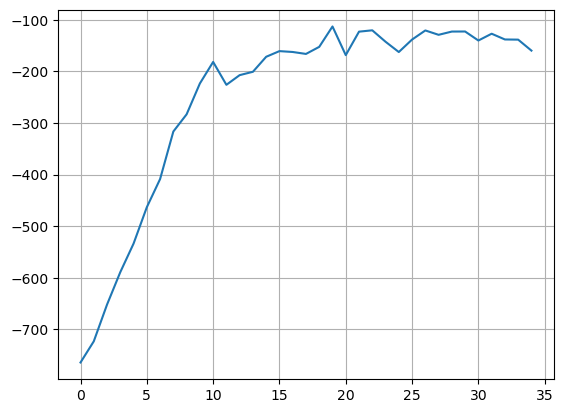

In [83]:
print(f'Mean total reard = {history_rewards[-1]}')
plt.plot(history_rewards)
plt.grid()
plt.show()

Общее вознаграждение по порядку такое же, как и в предыдущих случаях, но визуально агент играет лучше

In [14]:
#test
env = gym.make('Taxi-v3')
obs = env.reset()
state = obs

for _ in range(trajectory_len):

    action = agent.get_action(state)

    obs, reward, done, _ = env.step(action)
    state = obs
    
    
    env.render()
    time.sleep(0.2)

    if done:
        break

        
env.close()